In [ ]:
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
plt.style.use("default")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

DATA_PATH = "datasets/summit_dbe_processed_with_time.parquet"
df = pd.read_parquet(DATA_PATH)

print(df.shape)
df.head()

(50259, 150)


In [9]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(["hostname", "GPU", "serial", "timestamp"]).reset_index(drop=True)

#30 minutes = 6 steps if rows are 5-minute aggregates

df["lead30"] = (
df.groupby(["hostname", "GPU", "serial"])["is_failure"]
.shift(-6)
)

df["lead30"] = df["lead30"].fillna(0).astype(int)

print("is_failure counts:")
print(df["is_failure"].value_counts())
print("\nlead30 counts:")
print(df["lead30"].value_counts())
print("\nPositive rate lead30:", df["lead30"].mean())

is_failure counts:
is_failure
0.0    49964
1.0      295
Name: count, dtype: int64

lead30 counts:
lead30
0    50169
1       90
Name: count, dtype: int64

Positive rate lead30: 0.0017907240494239838


In [10]:
df["power_dev"] = df["power_mean_1min"] - df["power_mean_1h"]
df["temp_dev"] = df["core_temp_max_1min"] - df["core_temp_mean_1h"]
df["mem_temp_dev"] = df["mem_temp_max_1min"] - df["mem_temp_mean_1h"]

df["power_ratio"] = df["power_mean_1min"] / (df["power_mean_1h"] + 1e-5)
df["temp_ratio"] = df["core_temp_max_1min"] / (df["core_temp_mean_1h"] + 1e-5)

print("Total features after deviation features:", df.shape[1])
print(df[["power_dev", "temp_dev", "mem_temp_dev", "power_ratio", "temp_ratio"]].head())

Total features after deviation features: 148
   power_dev  temp_dev  mem_temp_dev  power_ratio  temp_ratio
0  -1.200666  0.000000     -0.039595     0.977213    1.000000
1  -0.270614 -0.280198     -1.214311     0.992344    0.990092
2   0.000000  0.770703      0.912613     0.999999    1.023913
3  -2.359051  0.770703      0.912613     0.953046    1.023913
4  -5.265781 -0.355482     -0.837209     0.906412    0.989013


In [11]:
y = df["lead30"]

# Columns we must drop from X
drop_cols = [
    "is_failure",
    "lead30",
    "timestamp",
    "hostname"
]

# If GPU or serial are numeric, we also drop them because they are identifiers
drop_cols += ["GPU", "serial"]

X = df.drop(columns=drop_cols)

print("X shape:", X.shape)
print("y positives:", y.sum())
print("y positive rate:", y.mean())

X shape: (50259, 142)
y positives: 90
y positive rate: 0.0017907240494239838


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Train positives:", y_train.sum())
print("Test positives:", y_test.sum())
print("Train positive rate:", y_train.mean())
print("Test positive rate:", y_test.mean())

Train size: (40207, 142)
Test size: (10052, 142)
Train positives: 72
Test positives: 18
Train positive rate: 0.0017907329569477953
Test positive rate: 0.0017906884202148826


In [ ]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_weight = neg / pos

print("scale_pos_weight =", scale_weight)

model = XGBClassifier(
    n_estimators=600,            # number of trees
    max_depth=4,                 # controls how deep each tree grows
    learning_rate=0.03,          # size of each update during training
    subsample=0.8,               # percent of rows used per tree
    colsample_bytree=0.8,        # percent of features used per tree
    scale_pos_weight=scale_weight,  # boost weight for rare positive class
    min_child_weight=20,         # minimum samples needed to split a node
    gamma=1.0,                   # minimum loss reduction to allow a split
    tree_method="hist",          # fast tree building method
    n_jobs=-1,                   # use all CPU cores
    random_state=42              # fixed seed for repeatable results
)

model.fit(X_train, y_train)

print("Model trained.")

scale_pos_weight = 557.4305555555555
Model trained.


In [14]:
y_prob = model.predict_proba(X_test)[:, 1]

roc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

print("ROC-AUC:", roc)
print("PR-AUC:", pr_auc)

ROC-AUC: 0.9868834850397536
PR-AUC: 0.6982326253889808


In [15]:
thresholds = [0.5, 0.3, 0.2, 0.1, 0.05, 0.02, 0.01]

for t in thresholds:
    preds = (y_prob > t).astype(int)
    print("Threshold:", t)
    print(classification_report(y_test, preds, digits=3))
    print("-" * 50)

Threshold: 0.5
              precision    recall  f1-score   support

           0      0.999     0.999     0.999     10034
           1      0.524     0.611     0.564        18

    accuracy                          0.998     10052
   macro avg      0.762     0.805     0.782     10052
weighted avg      0.998     0.998     0.998     10052

--------------------------------------------------
Threshold: 0.3
              precision    recall  f1-score   support

           0      1.000     0.999     0.999     10034
           1      0.517     0.833     0.638        18

    accuracy                          0.998     10052
   macro avg      0.758     0.916     0.819     10052
weighted avg      0.999     0.998     0.999     10052

--------------------------------------------------
Threshold: 0.2
              precision    recall  f1-score   support

           0      1.000     0.998     0.999     10034
           1      0.390     0.889     0.542        18

    accuracy                       

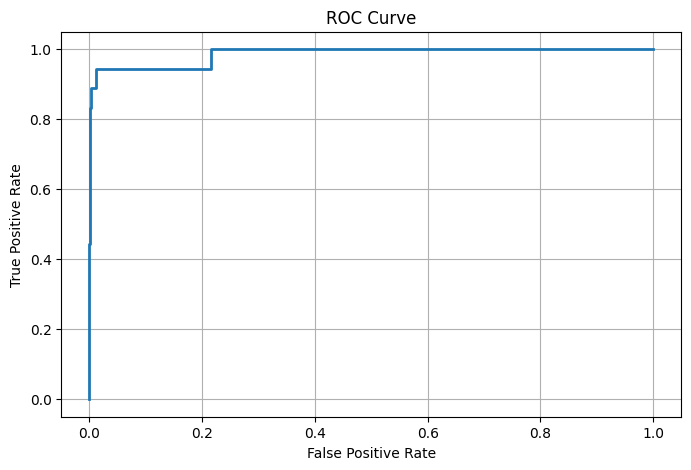

In [16]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, linewidth=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.show()

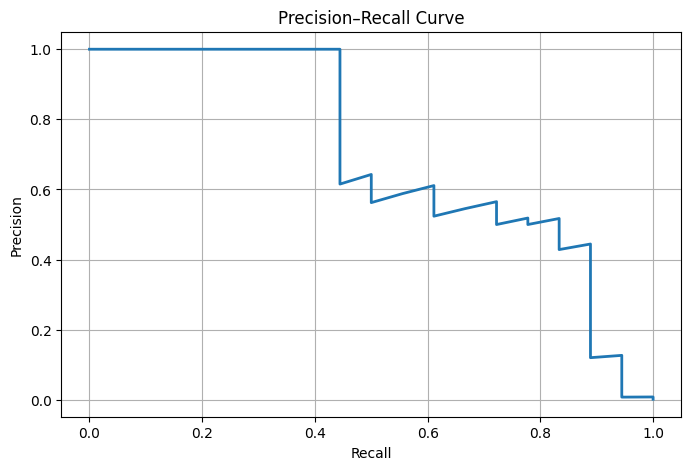

In [17]:
from sklearn.metrics import precision_recall_curve

prec, rec, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8,5))
plt.plot(rec, prec, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.show()

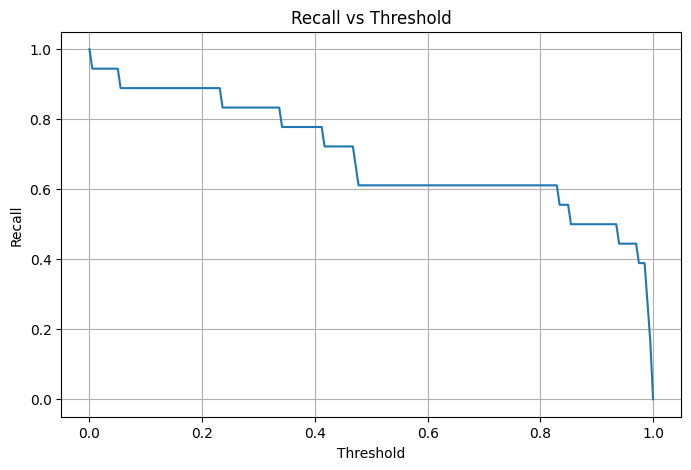

In [18]:
thresholds = np.linspace(0, 1, 200)
recalls = []

for t in thresholds:
    preds = (y_prob > t).astype(int)
    recalls.append((preds & (y_test == 1)).sum() / y_test.sum())

plt.figure(figsize=(8,5))
plt.plot(thresholds, recalls)
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.title("Recall vs Threshold")
plt.grid(True)
plt.show()

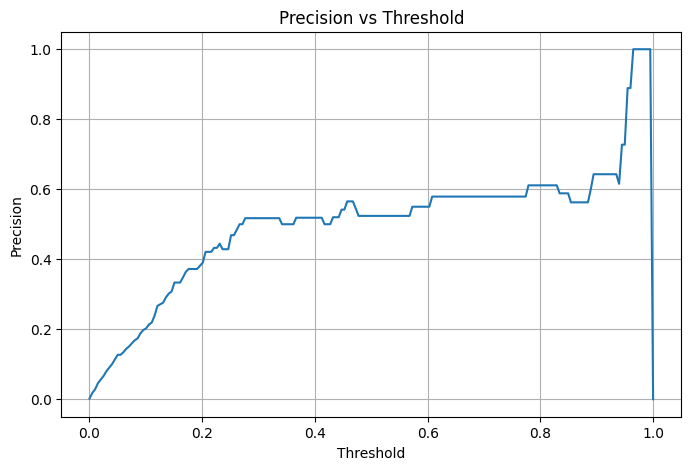

In [19]:
precisions = []

for t in thresholds:
    preds = (y_prob > t).astype(int)
    tp = ((preds == 1) & (y_test == 1)).sum()
    fp = ((preds == 1) & (y_test == 0)).sum()
    p = tp / (tp + fp) if (tp + fp) > 0 else 0
    precisions.append(p)

plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions)
plt.xlabel("Threshold")
plt.ylabel("Precision")
plt.title("Precision vs Threshold")
plt.grid(True)
plt.show()

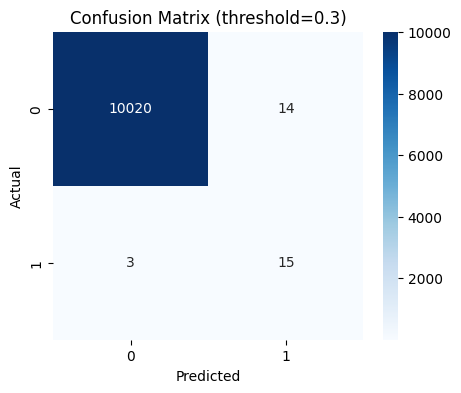

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Use threshold of your choice, for example 0.3
threshold = 0.3
preds = (y_prob > threshold).astype(int)

cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (threshold={threshold})")
plt.show()

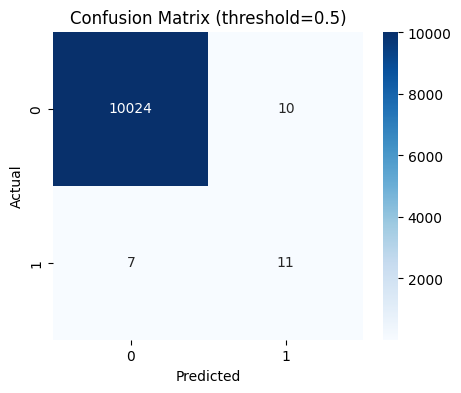

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Use threshold of your choice, for example 0.3
threshold = 0.5
preds = (y_prob > threshold).astype(int)

cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (threshold={threshold})")
plt.show()

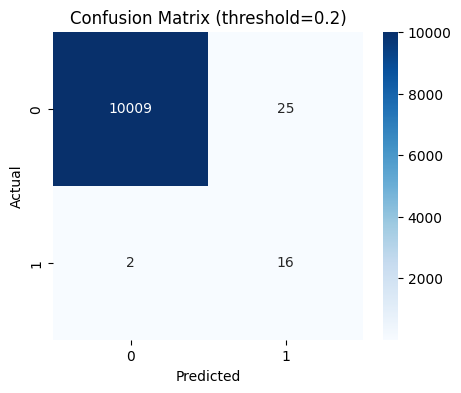

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Use threshold of your choice, for example 0.3
threshold = 0.2
preds = (y_prob > threshold).astype(int)

cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (threshold={threshold})")
plt.show()

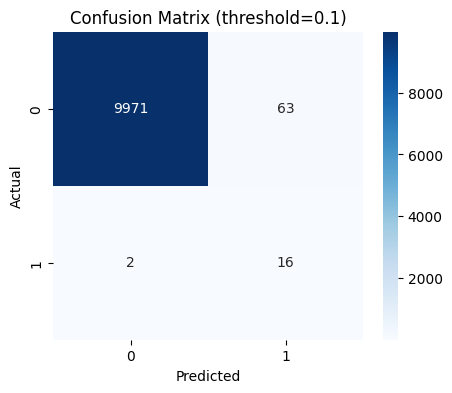

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Use threshold of your choice, for example 0.3
threshold = 0.1
preds = (y_prob > threshold).astype(int)

cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (threshold={threshold})")
plt.show()

In [25]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

c:\Users\latifa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


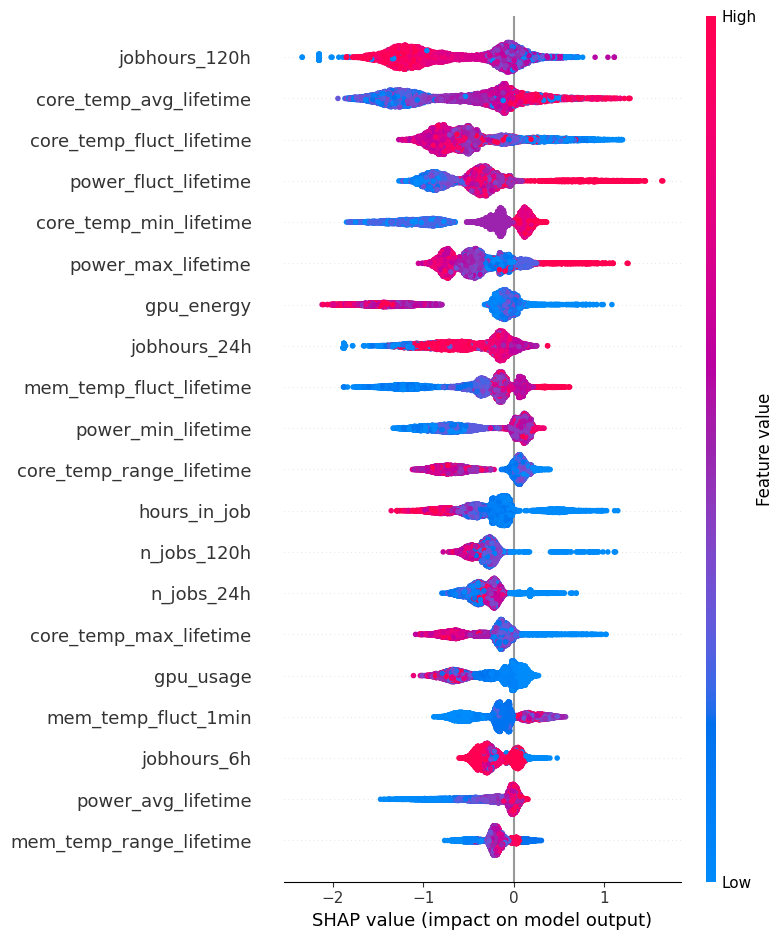

In [26]:
shap.summary_plot(shap_values, X_test, max_display=20)

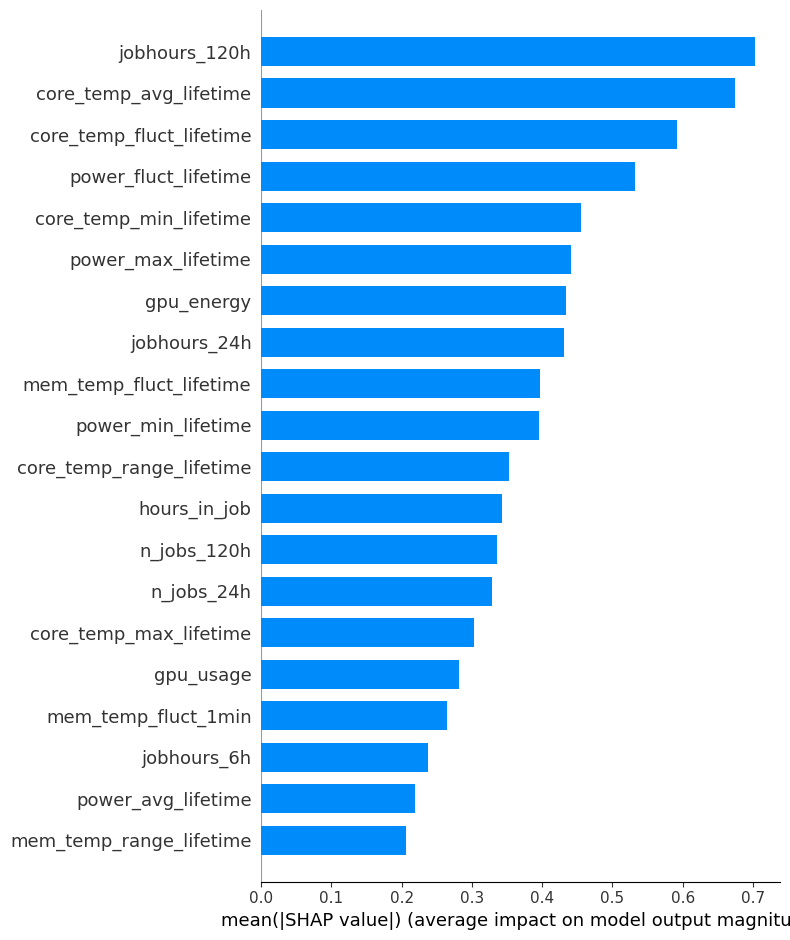

In [27]:
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)